In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams["font.family"] = "Arial"
# from skimage import measure
import pyvista as pv
pv.set_jupyter_backend('trame')
from tqdm import tqdm, trange
from scipy import interpolate, ndimage, fft
from scipy.io import savemat, loadmat
from time import time
from PIL import Image
from scipy.interpolate import splrep, splev
# from numba import jit


In [2]:
# random seed
np.random.seed(1145142)

## Define function


In [3]:
from Vortex import *

In [4]:
# def defect_density(vortex_volume, r_grid):
#     d_voxel = r_grid[0][0,1,0]-r_grid[0][0,0,0]
#     d_cell = [(r_grid[0][0,-1,0]-r_grid[0][0,0,0]),
#               (r_grid[1][-1,0,0]-r_grid[1][0,0,0]),
#               (r_grid[2][0,0,-1]-r_grid[2][0,0,0])] 
#     sum_voxel = np.sum(vortex_volume) # total volume of defective voxels (pixel^3)
#     cross_voxel = 4 # crossection of defective voxels (pixel^2)
#     length = sum_voxel/cross_voxel # length of defect line (pixel)

#     cell_volume = d_cell[0]*d_cell[1]*d_cell[2]
#     line_density = length*d_voxel/cell_volume

#     return(line_density)

# def scale_rho(rho, r_grid, scale):
#     rho = ndimage.zoom(rho, scale, order=1)
#     r_grid = np.array([ndimage.zoom(r, scale, order=1) for r in r_grid]) 
#     return rho, r_grid

In [5]:
## Generate random wave
def gen_vertex_lines(r_grid, sigma_k, kappa, alpha, d, box_size, x_scale=1, n_grid_scale=128):
    #### Wave vector distribution ####
    scale = box_size/d/2 # how many layers in the box
    k_mean_z = np.array([0,0,scale])*2*np.pi # lamellar perpendicular to z axis 
    # k_mean_x = np.array([0,0,0])*np.pi # lamellar perpendicular to z axis 
    k_var  = (np.array([0,0,sigma_k*scale])*2*np.pi)**2
    k_cov  = np.diagflat(k_var)

    ### generate randomwave
    rho = sample_wave_MO_complex(r_grid,k_mean_z,k_cov,n_wave = 100, kappa=kappa)

    scale_zoom = n_grid_scale/rho.shape[0]

    rho, r_grid = scale_rho(rho, r_grid, scale_zoom)

    rho_real = rho.real
    rho_imag = rho.imag
    rho_phase = np.angle(rho)

    vortex_volume = vortex_phase(rho_phase)

    ### Trace defect lines
    array = vortex_volume
    positions_tuple_list, positions_list, adjacent_list, adjacent_id_list = get_adjacency(array)
    poslist_arr = np.array(positions_tuple_list)

    sample, sample_adj_list, sample_adj_dict = get_core(positions_tuple_list, adjacent_id_list, 
                                                    cluster_size=3)
    sample_ordered = get_ordered_points(sample, sample_adj_list)

    sample_ordered_sm = []
    for line in sample_ordered:
        if len(line) == 0:
            continue
        if len(line)>5:
            x = np.arange(len(line))
            x_fine = np.arange(len(line)*x_scale)/x_scale
            arr_line = np.array(line)
            ll = len(line)
            spl_list = [splrep(x,arr_line[:,i],w=np.ones(len(line)),s=ll+np.sqrt(ll*2)) for i in range(3)]
            line_sm = np.array([splev(x_fine,spl) for spl in spl_list]).T
            sample_ordered_sm.append(line_sm)

        # else:
        #     sample_ordered_sm.append(line)
    return r_grid, rho_real, vortex_volume, sample_ordered_sm


In [6]:
# @jit
# def index_d_pair(points,index_in,rr,d_cell,pbc):
#     index_d_jk = []
#     dr = rr[1]-rr[0]
#     for i in tqdm(index_in):
#         r_ik = points - points[i].reshape(1,3)
#         for i_3 in range(3):
#             r_ik[:,i_3] = r_ik[:,i_3]-np.floor(r_ik[:,i_3]/d_cell[i_3])*d_cell[i_3]*pbc[i_3] # PBC
#         d_ik = np.sqrt(np.sum(r_ik**2,axis=1)) # pair distances
#         d_ik_list = d_ik[d_ik!=0] # pair distances, self exclusive
        
#         index_d_ik = np.floor(d_ik_list/dr).astype(int)
#         index_d_jk.extend(index_d_ik)
#     index_d_jk = np.array(index_d_jk)
#     index_d_jk = index_d_jk[index_d_jk<nr]
#     return index_d_jk

def segment_corr(points, bounds, rr=[], pbc=[0,0,0], be=False, line=False, vectorized=False):
    """
    Calculate spatial correlation of line segments
    
    Args:
        points: array
                point coordinates, N by 3 array

        bounds: list
                box bounds

        rr: array
            pair distances

        pbc: list
             periodic boundary condition
    """
    N = points.shape[0]
    print(points.shape)
    max_r = np.max(rr)
    nr = len(rr)
    dr = rr[1]-rr[0]

    d_cell = [(bounds[0][1]-bounds[0][0]),
            (bounds[1][1]-bounds[1][0]),
            (bounds[2][1]-bounds[2][0])]

    V = d_cell[0]*d_cell[1]*d_cell[2]

    #### handling with finite size effect ####
    index_in = np.arange(N)
    N_in = N
    
    if be:
        index_in_0 = (points[:,0]>=bounds[0][0])*(points[:,0]<bounds[0][1])
        index_in_1 = (points[:,1]>=bounds[1][0])*(points[:,1]<bounds[1][1])
        index_in_2 = (points[:,2]>=bounds[2][0])*(points[:,2]<bounds[2][1])
        index_in = index_in_0*index_in_1*index_in_2
        N_in = np.sum(index_in)
        index_in = np.where(index_in)[0] # transform to coordinate of True's

    rho = N_in/V

    #### two-point correlation ####
    if vectorized:
        # vectorized
        r_jk = points[index_in].reshape(N_in,1,3) - points.reshape(1,N,3) # pair vector
        # r_jk = r_jk-np.floor(r_jk/d_cell[0])*d_cell[0] 
        for i in range(3):
            r_jk[:,:,i] = r_jk[:,:,i]-np.floor(r_jk[:,:,i]/d_cell[i])*d_cell[i]*pbc[i] # PBC
        d_jk = np.sqrt(np.sum(r_jk**2,axis=2)) # pair distances
        d_jk_list = d_jk[d_jk!=0] # pair distances, self exclusive

        index_d_jk = np.floor(d_jk_list/dr).astype(int)
        index_d_jk = index_d_jk[index_d_jk<nr]

    else:
        # index_d_jk = index_d_pair(points,index_in,rr,d_cell,pbc)
        index_d_jk = []
        for i in tqdm(index_in):
            r_ik = points - points[i].reshape(1,3)
            # for i_3 in range(3):
            #     r_ik[:,i_3] = r_ik[:,i_3]-np.floor(r_ik[:,i_3]/d_cell[i_3])*d_cell[i_3]*pbc[i_3] # PBC
            r_ik -= np.floor(r_ik / d_cell) * d_cell * pbc
            d_ik = np.sqrt(np.sum(r_ik**2,axis=1)) # pair distances
            d_ik_list = d_ik[d_ik!=0] # pair distances, self exclusive
            index_d_ik = np.floor(d_ik_list/dr).astype(int)
            index_d_jk.extend(index_d_ik)
            
        index_d_jk = np.array(index_d_jk)
        index_d_jk = index_d_jk[index_d_jk<nr]

    #### histogram ####
    n_r = np.zeros(int(nr))
    g_r = np.zeros(int(nr))
    # np.add.at(n_r, index_d_jk, 1)
    for index in index_d_jk:
        n_r[index]+=1
    
    # normalization
    for ir in range(int(nr)):
        r_i = rr[ir]-dr/2
        
        # assuming line-like geometry
        if line: 
            g_r[ir] = n_r[ir]/N_in/rho/dr
        else:
            g_r[ir] = n_r[ir]/N_in/rho/(4*np.pi*dr*r_i**2)

    return g_r

## Fitting results

In [5]:
'''
30%
d = 64.6432 +- 3.3425
sigma_k = 0.6726% +- 0.1121%
kappa = 3.7827 +- 0.6305
alpha = 0.7027 +- 0.1171
f_AOT = 24.1135% +- 3.6500%


40%
d = 48.9493 +- 2.0980
sigma_k = 0.7797% +- 0.1299%
kappa = 2.6546 +- 0.4424
alpha = 0.4926 +- 0.0821
f_AOT = 31.1141% +- 2.9012%


50%
d = 38.9151 +- 1.7524
sigma_k = 0.2560% +- 0.0427%
kappa = 1.6590 +- 0.2765
alpha = 0.2992 +- 0.0499
f_AOT = 38.2404% +- 1.9021%
'''
wt_list = [30,40,50]
d_list = [64.6432,48.9493,38.9151]
sigma_k_list = [0.6726e-2, 0.7797e-2, 0.2560e-2]
kappa_list = [3.7827, 2.6546, 1.6590]
alpha_list = [0.7027, 0.4926, 0.2992]

In [8]:
rr = (np.arange(100)+1)
dr = rr[1]-rr[0]

## Generate random wave
n_grid = 100
n_grid_scale = 180
x = np.linspace(-1,1,n_grid+1)
y = np.linspace(-1,1,n_grid+1)
z = np.linspace(-1,1,n_grid+1)
r_grid_in = np.meshgrid(x,y,z) 

color_cycle = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
gr_list = []
for i, (sigma_k, kappa, alpha, wt, d) in enumerate(zip(sigma_k_list,kappa_list,alpha_list, wt_list, d_list)):
    # dynamic box size
    bs = 2*d # ~200
    box_size = bs*2+200 # ~600
    bounds = [[-bs,bs], [-bs,bs], [-bs,bs]]
    
    r_grid, rho_real, vortex_volume, sample_ordered_sm = gen_vertex_lines(r_grid_in, sigma_k, kappa, alpha, 
                                                                      d = d, box_size = box_size,
                                                                      x_scale=8, n_grid_scale = n_grid_scale)
    sample_all = np.vstack(sample_ordered_sm)
    points = sample_all/n_grid_scale*box_size-box_size/2
    gr = segment_corr(points, bounds, rr=rr, pbc=[0,0,0], be=True)
    gr_list.append(gr)
    

(42464, 3)


100%|██████████| 8359/8359 [00:19<00:00, 433.15it/s]


(59352, 3)


100%|██████████| 7034/7034 [00:31<00:00, 226.24it/s]


(114088, 3)


100%|██████████| 10110/10110 [01:48<00:00, 93.25it/s] 


In [9]:
mdic = {'gr_list':gr_list, 'rr':rr}
filename = './mat/results_autocorr.mat'

savemat(filename,mdic)

Text(0, 0.5, '$g(r)$')

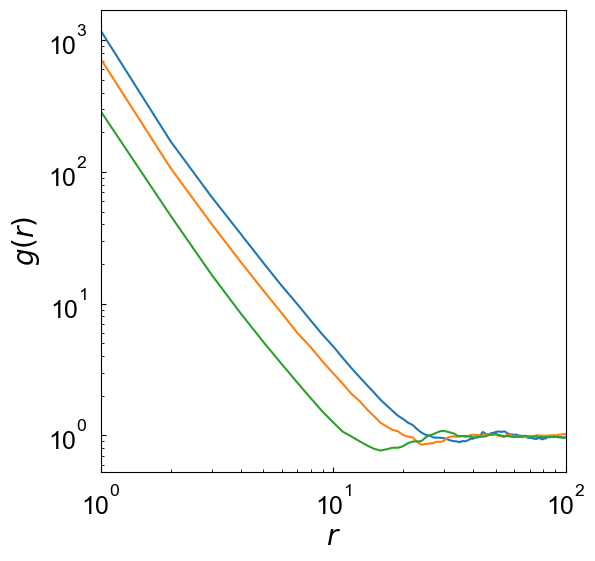

In [6]:
filename = './mat/results_autocorr.mat'
data = loadmat(filename)

gr_list = data['gr_list']
rr = data['rr'][0]

#### plotting
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1, 1, 1)

for i, (sigma_k, kappa, alpha, wt, d) in enumerate(zip(sigma_k_list,kappa_list,alpha_list, wt_list, d_list)):
    ax.plot(rr, gr_list[i], '-')

ax.set_xlim([1,100])
ax.set_yscale('log')
ax.set_xscale('log')
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)
ax.set_xlabel(r'$r$', fontsize=20)
ax.set_ylabel(r'$g(r)$', fontsize=20)

[-5.48223091  1.88429073]
19.88952246350176
[-5.76081554  2.0605264 ]
15.64447257558426
[-4.55359889  1.96897714]
10.418465324013358


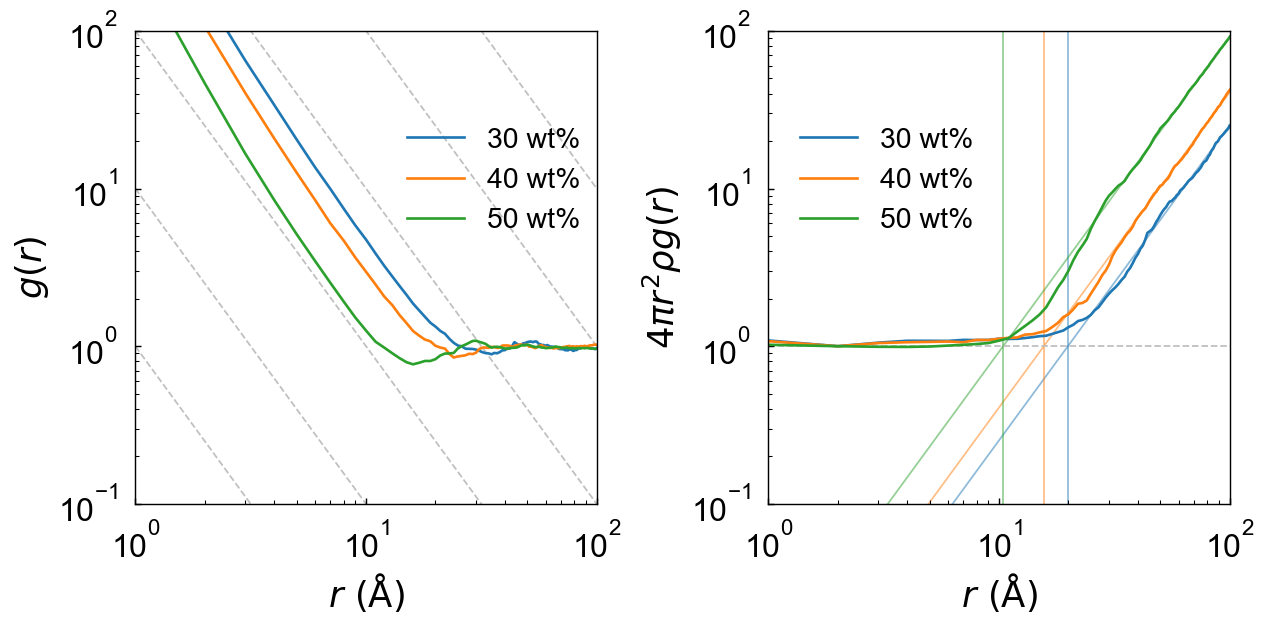

In [62]:
filename = './mat/results_autocorr.mat'
data = loadmat(filename)

gr_list = data['gr_list']
rr = data['rr'][0]
dr = rr[1]-rr[0]


#### plotting
fig = plt.figure(figsize=(10,5),dpi=128)
color_cycle = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
for i, (sigma_k, kappa, alpha, wt, d) in enumerate(zip(sigma_k_list,kappa_list,alpha_list, wt_list, d_list)):
    gr = gr_list[i]
    ax1 = plt.subplot(1, 2, 1)
    ax1.plot(rr, gr, '-', label='{} wt%'.format(wt))

    gr = gr_list[i]
    rhor = gr*(rr-dr/2)**2/(gr*(rr-dr/2)**2)[1]
    rhor[0]=np.mean(rhor[2:10])
    ax.plot(rr, rhor, '-')
    ax2 = plt.subplot(1, 2, 2)
    ax2.plot(rr, rhor, '-',color = color_cycle[i], label='{} wt%'.format(wt))
    
    rhor_end = np.log(rhor[50:])
    rr_end = np.log(rr[50:])
    rr_basis = np.vstack([np.ones_like(rr_end),rr_end])
    A = (rhor_end@rr_basis.T)@np.linalg.inv(rr_basis@rr_basis.T)
    print(A)
    rr_th = np.exp(A@np.vstack([np.ones_like(rr),np.log(rr)]))

    A_b = np.mean(rhor_end)-2*np.mean(rr_end)
    rr_th = np.exp(2*np.log(rr)+A_b)
    ax2.plot(rr, rr_th, '-',color = color_cycle[i],zorder=-10,lw=1, alpha=0.5)
    rr_0 = np.exp(-A_b/2)
    print(rr_0)
    ax2.plot([rr_0,rr_0], [0.1,100], '-',color = color_cycle[i],zorder=-10,lw=1, alpha=0.5)
    plt.arrow(rr_0, 0, 0, 0.1-1)
ax2.plot(rr, rr_th*0+1, '--',color='#C0C0C0',zorder=-10,lw=1)


ax1.set_xlim([1,100])
ax1.set_ylim([1e-1,1e2])
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)
ax1.set_xlabel(r'$r\ (\rm{Å})$', fontsize=20)
ax1.set_ylabel(r'$g(r)$', fontsize=20)
ax1.legend(fontsize=16,frameon=False, loc='upper right', bbox_to_anchor=(1.02, 0.85))

ax2.set_xlim([1,100])
ax2.set_ylim([1e-1,1e2])
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)
ax2.set_xlabel(r'$r\ (\rm{Å})$', fontsize=20)
ax2.set_ylabel(r'$4\pi r^2\rho g(r)$', fontsize=20)
plt.tight_layout()
ax2.legend(fontsize=16,frameon=False, loc='upper right', bbox_to_anchor=(0.5, 0.85))

# r^-2 decay
x = np.array([1,100])
y0_list = [0,1,2,3,4,5]
for y0 in y0_list:
    y = 10**y0/x**2
    ax1.plot(x, y, '--', color='#C0C0C0',zorder=-10,lw=1)

# interception

(8000, 3)


100%|██████████| 1533/1533 [00:01<00:00, 1365.58it/s]


(0.0, 2.0)

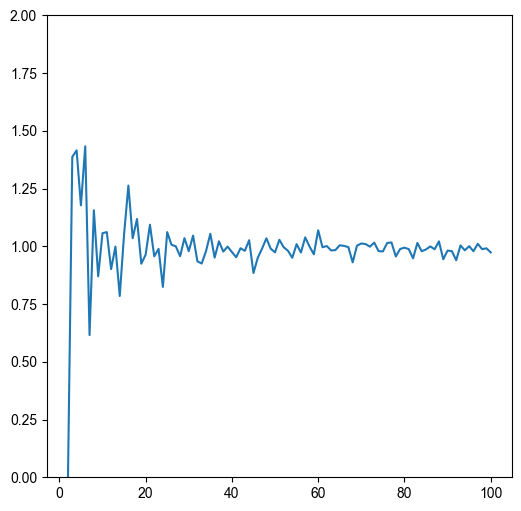

In [13]:
rr = (np.arange(100)+1)
dr = rr[1]-rr[0]

bounds = [[-200,200], [-200,200], [-200,200]]

np.random.seed(None)
## 1. Random uniform box filling
points = np.random.rand(8000,3)*700-350
gr_be = segment_corr(points, bounds, rr=rr, be=True)

#### plotting
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1, 1, 1)

# ax.plot(rr[1:], gr[1:])
ax.plot(rr[1:], gr_be[1:])

ax.set_ylim([0,2])

(5000, 3)


100%|██████████| 3352/3352 [00:00<00:00, 3358.87it/s]


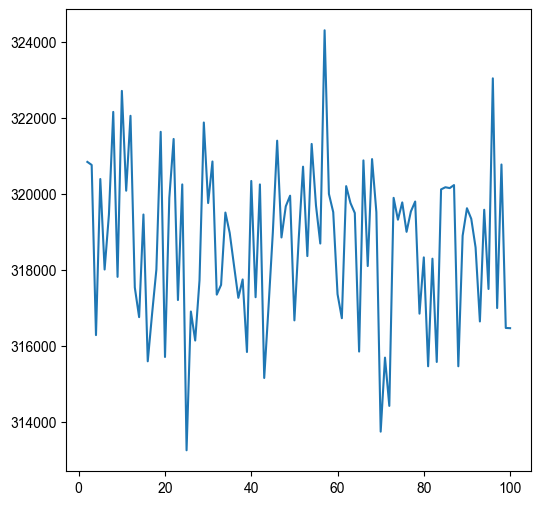

In [14]:
rr = (np.arange(100)+1)
dr = rr[1]-rr[0]

bounds = [[-200,200], [-200,200], [-200,200]]

np.random.seed(None)
x = np.random.rand(5000)*600-300
y = x*0
z = x*0
points = np.array([x,y,z]).T
gr_be = segment_corr(points, bounds, rr=rr, be=True,line=True)

#### plotting
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1, 1, 1)

# ax.plot(rr[1:], gr[1:])
ax.plot(rr[1:], gr_be[1:])

# ax.set_ylim([0,2])